In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import string

%matplotlib inline

In [103]:
# df = pd.read_csv('test.csv', sep='-', names=['position', 'band', 'song'])
# df['year'] = ''
# df = df.applymap(lambda x: x.lstrip().rstrip() if type(x) == str else x)

df = pd.read_csv('500_mais_with_year.csv', index_col=0, dtype={'year': str})
df.year.fillna('', inplace=True)

In [104]:
df.head()

,position,band,song,first_letter,year
0,500,AUDIOSLAVE,COCHISE,A,2002
1,499,BIG COUNTRY,IN A BIG COUNTRY,B,1983
2,498,LENNY KRAVITZ,LOW,L,2018
3,497,AC/DC,HARD AS A ROCK,A,1995
4,496,U2,BEAUTIFUL DAY,U,2000


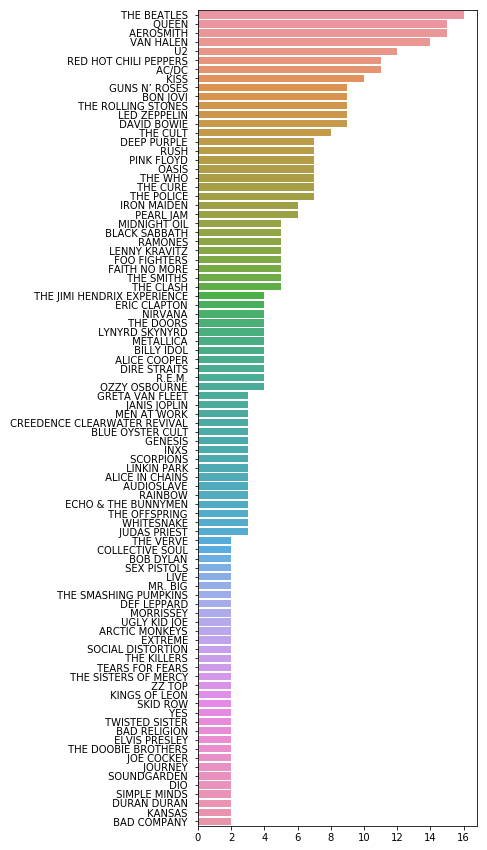

In [3]:
series = df.band.value_counts()[df.band.value_counts() > 1]

plt.figure(figsize=(5, 15))
sns.barplot(series.values, series.index);

In [4]:
def get_first_letter(band):
    band = band.lstrip()
    
    if band[:3].lower() == 'the':
        band = band[3:].lstrip()
    
    return band[0]

df['first_letter'] = df.band.map(get_first_letter)

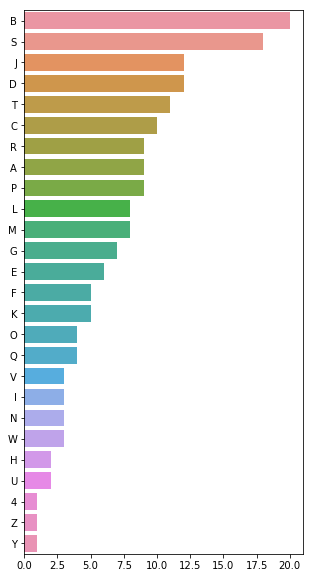

In [5]:
series = df.groupby(['first_letter', 'band']).position.count().reset_index().first_letter.value_counts()

plt.figure(figsize=(5, 10))
sns.barplot(series.values, series.index);

In [106]:
import re  # Import the regular expression library
 
Exclusions = [
    "a", "an", "the",  # Articles
    "and", "but", "or",  "by", "nor", "yet", "so",  # Conjunctions
    "about", "above", "across", "after", "against", "along", "among", "around", "at", "before",  # Prepositions
    "behind", "between", "beyond", "but", "by", "concerning", "despite", "down", "during",
    "except", "following", "for", "from", "in", "including", "into", "like", "near", "of",
    "off", "on", "out", "over", "plus", "since", "through", "throughout", "to", "towards",
    "under", "until", "up", "upon", "with", "within", 
#     "without",
    "my", "as" # others
 ]
 
def TitleCase(curText):
    """ Take a string and return it in a fashion that follows proper title case guidelines """
 
    outString = ""
    fragments = re.split( r'(\".*?\")|(\'.*?\')|(“.*?”)|(‘.*?’)', curText )     # Extract titles in quotation marks from string
 
    for fragment in fragments:                                                                  # Treat and re-assemble all fragments
        if fragment:                                                                                            # skip empty matches generated by the OR in regex   
            fragString = ""
            tokens = fragment.split();                                                          # Break string into individual words
 
            if tokens:
                for word in tokens:                                                                     # Check each word
 
                    punct = word[-1]                                                                        # Check for trailing punctuation mark
                    if punct.isalpha():
                        punct = ""
                    else:
                        word = word[:-1]
 
                    if word.lower() in Exclusions:                                          # if it is excluded,
                        fragString += word.lower() + punct + " "                    # make it lowercase
                    else:                                                                                               # otherwise,
                        fragString += word.capitalize() + punct + " "           # capitalize it
 
                cap = 1
                if not fragString[0].isalpha():
                    cap = 2
 
                outString += ( fragString[:cap].upper() + fragString[cap:]).strip() + " "
 
    return (outString[:1].upper() + outString[1:]).strip()          # Capitalize first letter and strip trailing space

In [109]:
request_worked = False
band_name_in_content = False


def make_request(URL, band_name):
    r = requests.get(URL)
    try:
        assert r.status_code == 200
        assert band_name.lower().lstrip().rstrip() in str(r.content).lower()
#         assert 'For the {} song, see'.format(band_name.lstrip().replace("\'", '\%27')\
#                                                 .replace("’", '\%27')).lower() \
#                                              not in str(r.content).lower() 
        assert 'For the {} song, see'.format(band_name.lstrip()\
                                                .replace("’", "\'")).lower() \
                                             not in str(r.content).lower() 
        return r
    except AssertionError:
        raise

def find_song_year(song_name, band_name, year=''):
    if year != '':
        return year
    
    song_name = "_".join(TitleCase(song_name).split())
    year = ''
    
#     base_URL = "https://en.wikipedia.org/wiki/{}".format(song_name.replace("\'", '\%27')\
#                                                 .replace("’", '\%27'))
    base_URL = "https://en.wikipedia.org/wiki/{}".format(song_name.replace("’", "\'"))
    
    try:
        URL = base_URL
        r = make_request(URL, band_name)
        soup = BeautifulSoup(r.content, 'html5lib')
        soup = soup.find_all(class_="infobox vevent")[0]
    except (IndexError, AssertionError):
        try:
            URL = base_URL + '_(song)'
            r = make_request(URL, band_name)
            soup = BeautifulSoup(r.content, 'html5lib')
            soup = soup.find_all(class_="infobox vevent")[0]
        except (IndexError, AssertionError):
            try:
#                 URL = base_URL + '_({}_song)'.\
#                      format("_".join(TitleCase(band_name.lstrip().replace("\'", '\%27')\
#                                             .replace("’", '\%27')).split()))
                URL = base_URL + '_({}_song)'.\
                     format("_".join(TitleCase(band_name.lstrip()\
                                            .replace("’", "\'")).split()))
                r = make_request(URL, band_name)
                soup = BeautifulSoup(r.content, 'html5lib')
                soup = soup.find_all(class_="infobox vevent")[0]
            except (IndexError, AssertionError):
                print('URL: {}, band_name: {}'.format(URL, band_name))
                return year
        
    try:
        released = soup.find_all('th', text='Released')[0]
    except IndexError:
        print('couldnt find Released at URL {}'.format(URL))
        return year
        
    try:
        released_date = released.find_next_siblings()[0]
        released_date = released_date.text.split()
    except IndexError:
        print('couldnt find released date at URL {}'.format(URL))
        return year
    
    for i in released_date:
        try:
            int(i)
            if len(i) == 4:
                year = i
        except:
            pass
    
    return year

In [112]:
df['year'] = df.apply(lambda row: find_song_year(row.song, row.band, row.year), axis=1)

# really not present on wikipedia:
# full circle
# not enouugh
# take cover
# in the midnight hour
# police on my back
# King of the Mountain

URL: https://en.wikipedia.org/wiki/Full_Circle_(Aerosmith_song), band_name: AEROSMITH
URL: https://en.wikipedia.org/wiki/Not_Enough_(Van_Halen_song), band_name: VAN HALEN
URL: https://en.wikipedia.org/wiki/Take_Cover_(Mr._Big_song), band_name: MR. BIG
URL: https://en.wikipedia.org/wiki/In_the_Midnight_Hour_(The_Commitments_song), band_name: THE COMMITMENTS
URL: https://en.wikipedia.org/wiki/Police_on_my_Back_(The_Clash_song), band_name: THE CLASH
URL: https://en.wikipedia.org/wiki/King_of_the_Mountain_(Midnight_Oil_song), band_name: MIDNIGHT OIL
URL: https://en.wikipedia.org/wiki/Burnin'_for_You_(Blue_Öyster_Cult_song), band_name: BLUE ÖYSTER CULT
URL: https://en.wikipedia.org/wiki/8675309_/_Jenny_(Tommy_Tutone_song), band_name: TOMMY TUTONE
URL: https://en.wikipedia.org/wiki/I_Still_Haven't_Found_What_I'm_Looking_for_(U2_song), band_name: U2
URL: https://en.wikipedia.org/wiki/Shake_my_Tree_(Coverdale/page_song), band_name: COVERDALE/PAGE
URL: https://en.wikipedia.org/wiki/Sunday_Morni

In [116]:
df.year.value_counts()[df.year.value_counts().index == '']

    100
Name: year, dtype: int64

In [117]:
df.to_csv('500_mais_with_year.csv')

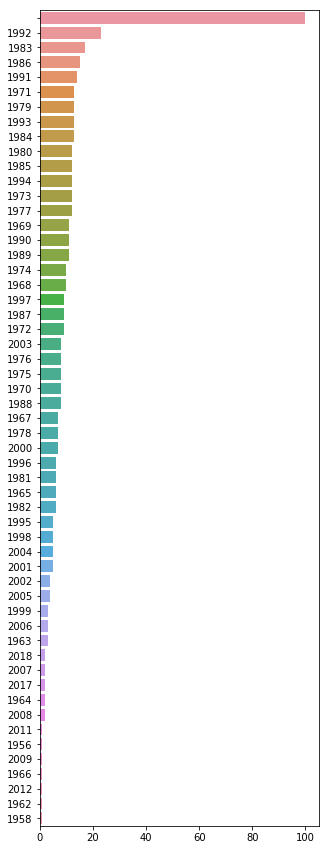

In [118]:
series = df.year.value_counts()

plt.figure(figsize=(5,15))
sns.barplot(series.values, series.index)

In [119]:
df['decade'] = df.year.map(lambda x: str(int(x) // 10) + '0s' if x != '' else '')

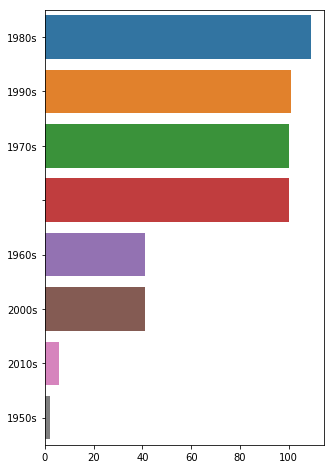

In [120]:
series = df.decade.value_counts()

plt.figure(figsize=(5,8))
sns.barplot(series.values, series.index)